# Note

This notebook showcases how to use Snowflake to load data, train a model and deploy it using the Snowflake Model Registry. For a comprehensive understanding of why certain filters are applied and how to diagnose regression models, refer to the Oreilly training I made some time ago and its notebook:
https://github.com/saox/regression_models_training/tree/main

# Imports

Requires libs versions to be listed on the Snowflake Anaconda Channel or provided manually in the conda_dependencies argument when pushing to model registry
https://repo.anaconda.com/pkgs/snowflake/

In [ ]:
# pip install mpu

In [ ]:
# !conda install -c https://repo.anaconda.com/pkgs/snowflake \
#     numpy scikit-learn pandas pyproj seaborn scipy \
#     snowflake-snowpark-python snowflake-ml-python -y

In [6]:
from snowflake.ml.model import model_signature

In [8]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import r2_score
from sklearn import metrics
from snowflake.ml.modeling.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
from snowflake.ml.modeling.ensemble import RandomForestRegressor
import mpu
import pyproj
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from snowflake.ml.modeling.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

In [9]:
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION

from snowflake.ml.registry import Registry
from snowflake.ml.model import custom_model
from snowflake.ml.model import model_signature

# from pycaret.classification import predict_model, load_model
import json
import os
import shutil
# warning suppresion
import warnings; warnings.simplefilter('ignore')
current_year = 2025
geodesic = pyproj.Geod(ellps='WGS84')

# Snowflake setup

In [ ]:
# USE ROLE ACCOUNTADMIN;
# CREATE OR REPLACE WAREHOUSE REG_MODEL_WH;--by default, this creates an XS Standard Warehouse
# CREATE OR REPLACE DATABASE REG_MODEL_DB; 
# CREATE OR REPLACE SCHEMA REG_MODEL_SCHEMA; 

In [ ]:
# To run this
# You will need to load the dataset.csv into a snowflake table and also this other table for the sake of the demo:

# create or replace TABLE REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE_DATES (
# 	ID NUMBER(38,0) NOT NULL,
# 	LISTING_DATE DATE,
# 	primary key (ID)
# );

# then execute create_table.sql to populate this table (haven't tried, but should work! Let me know if it doesn't)

# Do the same for the other table:

# create or replace TABLE REAL_ESTATE (
# 	ID NUMBER(38,0),
# 	SQM_PRICE NUMBER(38,13),
# 	BUILDING_FLOORS_NUM NUMBER(38,0),
# 	ROOMS_NUM NUMBER(38,0),
# 	LAT NUMBER(38,15),
# 	LONG NUMBER(38,15),
# 	BUILD_YEAR NUMBER(38,0),
# 	PRICE NUMBER(38,2),
# 	SQM NUMBER(38,2),
# 	FLOOR_NO NUMBER(38,0),
# 	WORD_PARKING NUMBER(38,0),
# 	WORD_BALCONY NUMBER(38,0),
# 	WORD_BASEMENT NUMBER(38,0),
# 	BUILDING_TYPE VARCHAR(16777216),
# 	WORD_ELEVATOR NUMBER(38,0)
# );

# Then load dataset.csv into this table: REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE

# Import libraries

In [8]:
import getpass
connection_parameters = json.load(open('connection.json'))
connection_parameters['password'] = getpass.getpass()

session = Session.builder.configs(connection_parameters).create()

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

 ········



Connection Established with the following parameters:
User                        : KILCZUK
Role                        : "ACCOUNTADMIN"
Database                    : "REG_MODEL_DB"
Schema                      : "REG_MODEL_SCHEMA"
Warehouse                   : "REG_MODEL_WH"
Snowflake version           : 9.6.0
Snowpark for Python version : 1.28.0


# Additional data points

## Query the main dataset

In [10]:
query = """
SELECT
  *
FROM
  REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE;
"""
df = session.sql(query).to_pandas()
# df.columns = df.columns.str.lower()
snowpark_df = session.create_dataframe(df) #Make it a Snowpark DF

# Query the listing date dataset

In [20]:
query_dates = """
SELECT
  *
FROM
  REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE_DATES;
"""
df_dates = session.sql(query_dates).to_pandas()
snowpark_df = session.create_dataframe(df_dates) #Make it a Snowpark DF
df_dates.tail()

,ID,LISTING_DATE
17895,17897,2025-03-30
17896,17898,2025-01-08
17897,17899,2025-03-06
17898,17900,2025-03-12
17899,13337,1970-01-01


# Feature Store

Instantiate the feature store, define an entity of your data. The entity will be used as a join key between the datasets. You can chose to do it this way, by defining feature views on every single SQL table/template, but you can also join it manually and have 1 larger query, with multiple CTEs if you feel that is preferable.

In [22]:
from snowflake.ml.feature_store import (
    FeatureStore,
    FeatureView,
    Entity,
    CreationMode
)

fs = FeatureStore(
    session=session, 
    database=session.get_current_database(), 
    name=session.get_current_schema(), 
    default_warehouse=session.get_current_warehouse(),
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST,
)

apartment_entity = Entity(name="apartment", join_keys=["ID"],desc="Primary Key for apartment")
fs.register_entity(apartment_entity)

Entity(name=APARTMENT, join_keys=['ID'], owner=None, desc=Primary Key for apartment)

Define and register a feature view for each dataset. Providing a refresh-rate creates a Snowflake Dynamic Table that automatically updates when the underlying data gets new records.

In [26]:
fv_name = "real_estate_fv"
description = {
  "SQM_PRICE": "Price per square meter of the property.",
  "BUILDING_FLOORS_NUM": "Total number of floors in the building.",
  "ROOMS_NUM": "Total number of rooms in the property.",
  "LAT": "Latitude coordinate of the property location.",
  "LONG": "Longitude coordinate of the property location.",
  "BUILD_YEAR": "Year the building was constructed.",
  "PRICE": "Total price of the property.",
  "SQM": "Total area of the property in square meters.",
  "FLOOR_NO": "Floor number on which the property is located.",
  "WORD_PARKING": "Indicator of whether the property mentions parking.",
  "WORD_BALCONY": "Indicator of whether the property mentions a balcony.",
  "WORD_BASEMENT": "Indicator of whether the property mentions a basement.",
  "BUILDING_TYPE": "Type of building, e.g., apartment, house, etc.",
  "WORD_ELEVATOR": "Indicator of whether the property mentions an elevator."
}

fv_instance = FeatureView(
  name=fv_name, 
  entities=[apartment_entity], 
  feature_df=session.sql(query),    
  refresh_freq="1 minute",            # <- specifying optional refresh_freq creates FeatureView as Dynamic Table, else created as View.
  desc="Features to support our magic use case").attach_feature_desc(description)

# Register the FeatureView instance.  Creates  object in Snowflake
fv_instance_register = fs.register_feature_view(
  feature_view=fv_instance, 
  version="1", 
  block=True
)


fv_instance_2 = FeatureView(
  name=fv_name, 
  entities=[apartment_entity], 
  feature_df=session.sql("""
SELECT
  * exclude(WORD_PARKING,WORD_BASEMENT,WORD_ELEVATOR) 
FROM
  REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE;
"""
),    
  refresh_freq="1 minute",            # <- specifying optional refresh_freq creates FeatureView as Dynamic Table, else created as View.
  desc="Features to support our magic use case").attach_feature_desc({
  "SQM_PRICE": "Price per square meter of the property.",
  "BUILDING_FLOORS_NUM": "Total number of floors in the building.",
  "ROOMS_NUM": "Total number of rooms in the property.",
  "LAT": "Latitude coordinate of the property location.",
  "LONG": "Longitude coordinate of the property location.",
  "BUILD_YEAR": "Year the building was constructed.",
  "PRICE": "Total price of the property.",
  "SQM": "Total area of the property in square meters.",
  "FLOOR_NO": "Floor number on which the property is located.",
  # "WORD_PARKING": "Indicator of whether the property mentions parking.",
  "WORD_BALCONY": "Indicator of whether the property mentions a balcony.",
  # "WORD_BASEMENT": "Indicator of whether the property mentions a basement.",
  "BUILDING_TYPE": "Type of building, e.g., apartment, house, etc."
  # "WORD_ELEVATOR": "Indicator of whether the property mentions an elevator."
}
)

# Register the FeatureView instance.  Creates  object in Snowflake
fv_instance_register = fs.register_feature_view(
  feature_view=fv_instance_2, 
  version="3", 
  block=True
)

In [28]:
fv_name = "real_estate_dates_fv"
description = {
  "LISTING_DATE":"Date of listing.",
}

fv_instance_dates = FeatureView(
  name=fv_name, 
  entities=[apartment_entity], 
  feature_df=session.sql(query_dates),    
  refresh_freq="1 minute",            # <- specifying optional refresh_freq creates FeatureView as Dynamic Table, else created as View.
  desc="Features to support our magic use case").attach_feature_desc(description)

# Register the FeatureView instance.  Creates  object in Snowflake
fv_instance_register_dates = fs.register_feature_view(
  feature_view=fv_instance_dates, 
  version="1", 
  block=True
)

We can inspect the feature views

In [30]:
pd.DataFrame(fv_instance_register.feature_descs.items(), columns=['Name', 'Desc']).style

,Name,Desc
0,SQM_PRICE,Price per square meter of the property.
1,BUILDING_FLOORS_NUM,Total number of floors in the building.
2,ROOMS_NUM,Total number of rooms in the property.
3,LAT,Latitude coordinate of the property location.
4,LONG,Longitude coordinate of the property location.
5,BUILD_YEAR,Year the building was constructed.
6,PRICE,Total price of the property.
7,SQM,Total area of the property in square meters.
8,FLOOR_NO,Floor number on which the property is located.
9,WORD_BALCONY,Indicator of whether the property mentions a balcony.


In [32]:
pd.DataFrame(fv_instance_register_dates.feature_descs.items(), columns=['Name', 'Desc']).style

,Name,Desc
0,LISTING_DATE,Date of listing.


Retreive the dataset using the generate_training_set function. There is another one called generate_dataset, but that one materializes it as a table and is hence not re-runable without specifying a new name each time (as of march 2025).

In [40]:
df = fs.generate_training_set(
    spine_df=session.sql(f"select ID from REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE_DATES"),
    features=[fv_instance_register_dates,fv_instance_register]
).to_pandas()

In [41]:
df.tail()

,ID,LISTING_DATE,SQM_PRICE,BUILDING_FLOORS_NUM,ROOMS_NUM,LAT,LONG,BUILD_YEAR,PRICE,SQM,FLOOR_NO,WORD_BALCONY,BUILDING_TYPE
17894,17896,2025-03-28,11836.363636,6,2,52.224595,20.943523,2012,651000.0,55.0,5,0,blok
17895,17897,2025-03-30,10387.640449,3,4,52.238358,20.933233,2001,924500.0,89.0,3,1,blok
17896,17898,2025-01-08,7957.393484,4,4,52.217934,20.901961,1991,635000.0,79.8,2,0,blok
17897,17899,2025-03-06,11478.260870,4,3,52.209800,20.964459,1963,528000.0,46.0,3,1,blok
17898,17900,2025-03-12,11887.417219,10,3,52.229765,20.934940,2006,718000.0,60.4,6,1,blok


You can test inserting/deleting an item into the data and seeing what happens. Will the Dynamic Table refesh the feature view? ;-) Insert/delete both rows (the join will not work if only one table has it) and wait for one minute.

In [38]:
def insert_real_estate_record(session, id, sqm_price, building_floors_num, rooms_num, lat, long, build_year, price, sqm, floor_no, word_parking, word_balcony, word_basement, building_type, word_elevator):
    query = """
    INSERT INTO REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE (
        ID, SQM_PRICE, BUILDING_FLOORS_NUM, ROOMS_NUM, LAT, LONG, BUILD_YEAR, PRICE, 
        SQM, FLOOR_NO, WORD_PARKING, WORD_BALCONY, WORD_BASEMENT, BUILDING_TYPE, WORD_ELEVATOR
    ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """
    values = (id, sqm_price, building_floors_num, rooms_num, lat, long, build_year, price, sqm, floor_no, word_parking, word_balcony, word_basement, building_type, word_elevator)
    formatted_query = query.replace("%s", "{}").format(*values).replace("None","NULL")
    print(formatted_query)
    session.sql(formatted_query).collect()
    # conn.cursor().execute(formatted_query) 

def insert_real_estate_dates_record(session, id, listing_date):
    query = """
    INSERT INTO REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE_DATES (
        ID, LISTING_DATE
    ) VALUES (%s, DATE(%s))
    """
    values = (id, listing_date)
    formatted_query = query.replace("%s", "{}").format(*values).replace("None","NULL")
    print(formatted_query)
    session.sql(formatted_query).collect()
    # conn.cursor().execute(formatted_query) 

def delete_real_estate_record(session, id):
    query = "DELETE FROM REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE WHERE ID = %s"
    formatted_query = query.replace('%s',str(id))
    print(formatted_query)
    session.sql(formatted_query).collect()
    # conn.cursor().execute(formatted_query)

def delete_real_estate_dates_record(session, id):
    query = "DELETE FROM REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE_DATES WHERE ID = %s"
    formatted_query = query.replace('%s',str(id))
    print(formatted_query)
    session.sql(formatted_query).collect()
    # conn.cursor().execute(formatted_query)


id = 13337

# insert_real_estate_record(
#     session=session,
#     id=id, 
#     sqm_price=None, 
#     building_floors_num=10, 
#     rooms_num=2, 
#     lat=52.150180, 
#     long=21.050850, 
#     build_year=2013, 
#     price=None, 
#     sqm=47.5, 
#     floor_no=9, 
#     word_parking=None, 
#     word_balcony=None, 
#     word_basement=None, 
#     building_type=None, 
#     word_elevator=None
# )

# insert_real_estate_dates_record(session,id,"2025-02-10")

# delete_real_estate_record(session=session,id=id)
# delete_real_estate_dates_record(session=session,id=id)

DELETE FROM REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE WHERE ID = 13337
DELETE FROM REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE_DATES WHERE ID = 13337


In [ ]:
session.sql("SELECT * FROM REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE").to_pandas().tail()

In [ ]:
# my_dataset.read.to_pandas().tail()

In [44]:
def homoscedasticity(model, test_df, variables, y_test):
    # Fit the linear regression model and obtain residuals
    y_pred = model.predict(test_df[variables])
    residuals = y_test - y_pred

    # Plot the residuals against the predicted values
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_pred, residuals)
    ax.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0

    # Set labels and title
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title('Residuals vs Predicted Values')

    # Show the plot
    plt.show()

def pred_vs_true(model, X_test, y_test):
    preds = model.predict(X_test)
    true_values = y_test
    print(np.corrcoef(preds,true_values)[0, 1])

    plt.scatter(preds,true_values)
    plt.plot([min(preds), max(preds)], [min(true_values), max(true_values)], color='red', linestyle='--', label='y = x')
    plt.title("Predictions(x) vs true values (y)")
    plt.xlabel("Predictions")
    plt.ylabel("True values")
    return plt.show()

def test_normality(model, test_df, variables, y_test):
    y_pred = model.predict(test_df[variables])
    residuals = y_test - y_pred

    # Perform Shapiro-Wilk test for normality
    statistic, p_value = stats.shapiro(residuals)

    # Set the significance level
    alpha = 0.05

    # Check the null hypothesis
    if p_value > alpha:
        print("Residuals are normally distributed (fail to reject H0)")
    else:
        print("Residuals are not normally distributed (reject H0)")



def corr_matrix(df):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create the correlation matrix heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)

    # Set the title
    ax.set_title('Correlation Matrix')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()
    
    
def calculate_mape(y_test, preds):
    #y_test = np.array(y_test)
    # preds = np.array(preds)
    
    non_zero_indices = y_test != 0
    y_test = y_test[non_zero_indices]
    preds = preds[non_zero_indices]
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
    
    return mape    

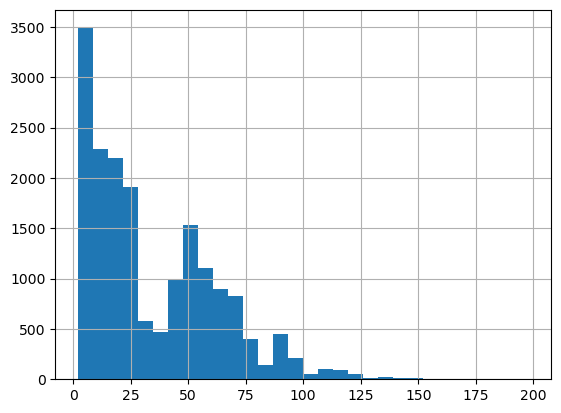

In [46]:
def remove_outliers(df):
    df = df[(df.LONG < 21.3) & (df.LAT > 52.05)]
    df = df[df.BUILDING_FLOORS_NUM <=25]
    df = df[df.ROOMS_NUM <= 10]
    df['BUILDING_AGE'] = current_year - df['BUILD_YEAR']
    df['LOG_PRICE'] = np.log(df.PRICE)
    return df

# Forward Azimuth - the direction in which the apartment lies measured from a center
# Distance - distance from that center
# Together in a non-linear model these features reflect a zone/segment of the city in which the apartment is located

def adv_features(df):
    df['FWD_AZIMUTH_CENTER'] = df.apply(lambda x: 180 + geodesic.inv(x.LAT, x.LONG, center[0], center[1])[0],axis=1)
    df['DISTANCE_FROM_CENTER'] = df.apply(lambda x: mpu.haversine_distance( (x.LAT,x.LONG),(center)),axis=1)
    return df

# Define a center of the city
center = (df.LAT.mean(),df.LONG.mean())
df = remove_outliers(df)
df['BUILDING_AGE'].hist(bins = 30)
df = adv_features(df)

Some custom datapoints

In [48]:
def datapoint(build_year,building_floors_no,sqm,rooms_num,floor_no,ad_lat,ad_long, word_balkon_taras=1,
 word_winda=1,
 word_postoj=1,
 word_piwnica_komorka=1):
    dp = pd.DataFrame({
    'BUILDING_AGE': current_year - build_year,
    'BUILDING_FLOORS_NUM': building_floors_no,
    'SQM': sqm,
    'ROOMS_NUM': rooms_num,
    'FLOOR_NO': floor_no,
    'DISTANCE_FROM_CENTER': mpu.haversine_distance((ad_lat, ad_long), (center)),
    'FWD_AZIMUTH_CENTER': 180 + geodesic.inv(ad_lat, ad_long, center[0], center[1])[0],
    'WORD_BALCONY': word_balkon_taras,
    'WORD_WINDA': word_winda,
    'WORD_POSTOJ': word_postoj,
    'WORD_PIWNICA_KOMORKA': word_piwnica_komorka
}, index=[0])
    #dp['fwd_azimuth_center'] = pd.cut(dp['fwd_azimuth_center'], [-float("inf"),80,150,230,325,float("inf")]).astype('category')
    
    #dp = make_categorical(dp,'fwd_azimuth_center')
    dp.columns = dp.columns.str.replace("[. [)(]", "").str.replace(',',"x").str.replace(']','')    
    return dp

app1 = datapoint(build_year=2020, building_floors_no=8, sqm=67, rooms_num=3, floor_no=2, ad_lat=52.249290, ad_long=21.031700) 
app2 = datapoint(build_year=2019, building_floors_no=6, sqm=50, rooms_num=2, floor_no=2, ad_lat=52.302700, ad_long=20.992160) 
app3 = datapoint(build_year=2015, building_floors_no=2, sqm=105, rooms_num=8, floor_no=1, ad_lat=52.002326, ad_long=21.022399)
app4 = datapoint(build_year=1955, building_floors_no=4, sqm=62, rooms_num=3, floor_no=4, ad_lat=52.218630, ad_long=21.021380) 
app5 = datapoint(build_year=2015, building_floors_no=6, sqm=58, rooms_num=3, floor_no=4, ad_lat=52.3361205, ad_long=20.9522429)
app6 = datapoint(build_year=2013, building_floors_no=10, sqm=47.5, rooms_num=2, floor_no=9, ad_lat=52.150180, ad_long=21.050850)

# Visualize center of the data and the city

Text(0.5, 1.0, 'Listings with marked center')

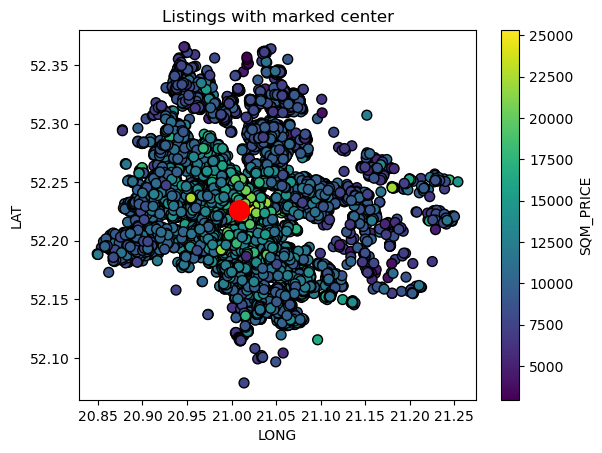

In [50]:
ax = df.plot.scatter(x='LONG', y='LAT', c='SQM_PRICE',cmap='viridis', edgecolors='k', s=50)

# Add a custom marker/point
custom_x = center[0]
custom_y = center[1]
custom_color = 'red'
ax.scatter(custom_y,custom_x, color=custom_color, marker='o', s=200, label='Center')

ax.set_title('Listings with marked center')

In [52]:
X_medium = ['sqm','building_age', 'building_floors_num', 'rooms_num','floor_no']
X_medium = [word.upper() for word in X_medium]
# Include advanced, custom made features
X_adv_medium = X_medium + ['distance_from_center','fwd_azimuth_center']
X_adv_medium = [word.upper() for word in X_adv_medium]

# Our variables and target variable
final_variables = X_adv_medium
target = 'price'.upper()
output_label = 'predicted_price'.upper()
# target = 'log_price'

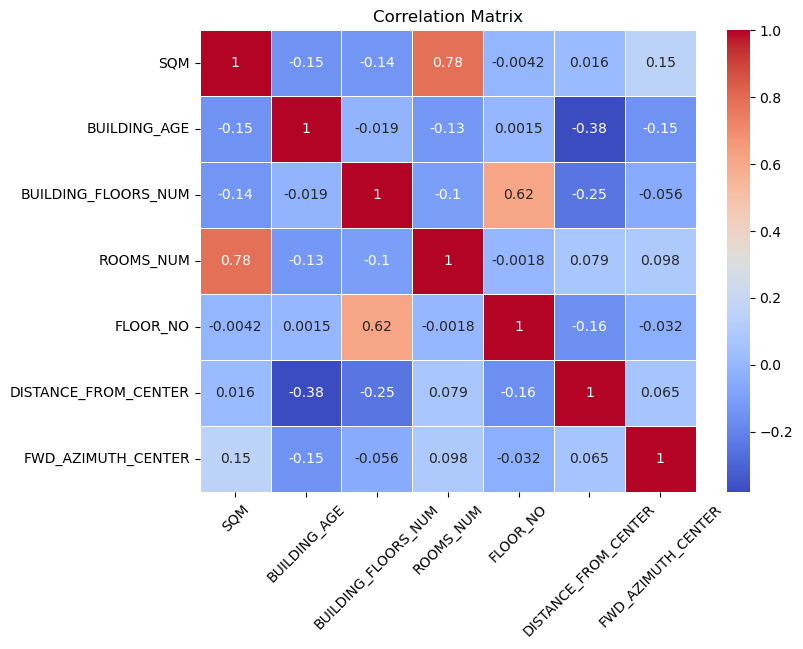

In [54]:
corr_matrix(df[final_variables])

# Define a custom made Model Wrapper

In [56]:
class ModelWrapper():
    def __init__(self,model,name):
        self.model = model
        self.name = name
        self.model_type = str(model).split("(")[0]
        
        self.r2 = []
        self.rms = []
        self.mae = []
        self.mape = []

    def train(self,train_df):
        self.model = self.model.fit(train_df)
        self.variables = train_df.columns
    
    def score_eval(self,test):

        preds = self.model.predict(test[final_variables])[output_label]
        
        self.r2.append(metrics.r2_score(test[target], preds))
        self.rms.append(np.sqrt(metrics.mean_squared_error(test[target], preds)))
        self.mae.append(metrics.mean_absolute_error(test[target],preds))
        self.mape.append(calculate_mape(test[target], preds))
        
    def aggregate_results(self):
        self.mean_r2 = round(sum(self.r2)/len(self.r2),2)
        self.mean_rms = round(sum(self.rms)/len(self.rms),2)
        self.mean_mae = round(sum(self.mae)/len(self.mae),2)
        self.mean_mape = round(sum(self.mape)/len(self.mape),2)

    def results_to_json(self):
        return {
            "mean_r2": self.mean_r2,
            "mean_rms": self.mean_rms,
            "mean_mae": self.mean_mae,
            "mean_mape":self.mean_mape
        }

# Train models, many different types to compare

In [58]:
models = [ModelWrapper(model = LinearRegression(fit_intercept = True,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'With Intercept'),
          ModelWrapper(model = LinearRegression(fit_intercept = False,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'No Intercept')
]

models += [ModelWrapper(model = DecisionTreeRegressor(criterion = 'friedman_mse',
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'c_friedman_mse'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 3, min_samples_split = 2,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'max_dp_3'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 5, min_samples_split = 2,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'max_dp_3'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 5, min_samples_split = 20,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'max_dp_5_min_split_20'),
          ModelWrapper(model = DecisionTreeRegressor(max_depth = 4, min_samples_split = 10,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'max_dp_4_min_split_10'),
          ModelWrapper(model = DecisionTreeRegressor(
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ),name='Default DT'), 
          ]

models += [ModelWrapper(model = RandomForestRegressor(n_estimators=2,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'rf_2'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=5,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'rf_5'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=10,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'rf_10'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=20,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'rf_20'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=50,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'rf_50'),
           ModelWrapper(model = RandomForestRegressor(n_estimators=100,
                                               input_cols = final_variables,
                                               label_cols = target,
                                               output_cols = output_label
                                                   ), name = 'rf_100'),
          ]

In [ ]:
# # train, test = session.create_dataframe(df[final_variables]).random_split([0.8, 0.2], seed=42)
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# feature_columns = final_variables
# output_label = 'predicted_price'

# print(target)
# print(f"feature cols: {feature_columns}")
# print(output_label)
# snow_linreg = LinearRegression(
#     input_cols = feature_columns,
#     label_cols = target,
#     output_cols = output_label
#                 ).fit(train_df)
# # RandomForestRegressor(n_estimators = 2,input_cols=train_df.columns, label_cols=target).fit(train_df)

In [ ]:
# df = df[df.ID!=13337]

Training the model

In [60]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=13)
# Split the data
for train_index, test_index in kf.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        
        # Train and evaluate the model(s)
        for m in models:
            m.train(train)
            m.score_eval(test)

In [61]:
# Aggregate results and display
data_rows = []

for m in models:
    
    m.aggregate_results()
    
    row_data = {
        'model':m.model_type,
        'name':m.name,
        'r2':m.mean_r2,
        'rms':m.mean_rms,
        'mae':m.mean_mae,
        'mape':m.mean_mape
    }
    
    data_rows.append(row_data)
agg_results = pd.DataFrame(data_rows)
agg_results

,model,name,r2,rms,mae,mape
0,<snowflake.ml.modeling.linear_model.linear_reg...,With Intercept,0.77,249884.91,156007.56,19.23
1,<snowflake.ml.modeling.linear_model.linear_reg...,No Intercept,0.76,255097.78,160059.16,19.56
2,<snowflake.ml.modeling.tree.decision_tree_regr...,c_friedman_mse,0.83,218572.79,102946.81,11.97
3,<snowflake.ml.modeling.tree.decision_tree_regr...,max_dp_3,0.72,274257.07,174734.77,21.69
4,<snowflake.ml.modeling.tree.decision_tree_regr...,max_dp_3,0.79,239912.10,148353.61,17.92
5,<snowflake.ml.modeling.tree.decision_tree_regr...,max_dp_5_min_split_20,0.79,239912.10,148353.61,17.92
6,<snowflake.ml.modeling.tree.decision_tree_regr...,max_dp_4_min_split_10,0.76,254310.01,160931.42,19.78
7,<snowflake.ml.modeling.tree.decision_tree_regr...,Default DT,0.82,220508.55,104079.35,12.05
8,<snowflake.ml.modeling.ensemble.random_forest_...,rf_2,0.84,207862.08,104193.13,11.93
9,<snowflake.ml.modeling.ensemble.random_forest_...,rf_5,0.88,178097.39,92458.27,10.62


# Feature views

Display what feature views do we have in our feature store?

In [80]:
fs.list_feature_views().to_pandas()

,NAME,VERSION,DATABASE_NAME,SCHEMA_NAME,CREATED_ON,OWNER,DESC,ENTITIES,REFRESH_FREQ,REFRESH_MODE,SCHEDULING_STATE,WAREHOUSE
0,REAL_ESTATE_DATES_FV,1,REG_MODEL_DB,REG_MODEL_SCHEMA,2025-03-20 03:31:05.616,ACCOUNTADMIN,Features to support our magic use case,"[\n ""APARTMENT""\n]",1 minute,INCREMENTAL,ACTIVE,REG_MODEL_WH
1,REAL_ESTATE_FV,1,REG_MODEL_DB,REG_MODEL_SCHEMA,2025-03-20 03:23:41.855,ACCOUNTADMIN,Features to support our magic use case,"[\n ""APARTMENT""\n]",1 minute,INCREMENTAL,ACTIVE,REG_MODEL_WH
2,REAL_ESTATE_FV,2,REG_MODEL_DB,REG_MODEL_SCHEMA,2025-03-24 01:28:46.245,ACCOUNTADMIN,Features to support our magic use case,"[\n ""APARTMENT""\n]",1 minute,INCREMENTAL,ACTIVE,REG_MODEL_WH
3,REAL_ESTATE_FV,3,REG_MODEL_DB,REG_MODEL_SCHEMA,2025-03-24 06:18:25.055,ACCOUNTADMIN,Features to support our magic use case,"[\n ""APARTMENT""\n]",1 minute,INCREMENTAL,ACTIVE,REG_MODEL_WH


Redifine variables used for model to include one from another feature view

In [84]:
final_variables = X_adv_medium + ["WORD_BALCONY"]

retrieve that feature view

In [82]:
new_feature_instance = fs.get_feature_view(
    name = "REAL_ESTATE_FV",
     version = "3"
)

In [86]:
df = fs.generate_training_set(
    spine_df=session.sql(f"select ID from REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE_DATES"),
    features=[fv_instance_register_dates,new_feature_instance]
).to_pandas()

Transform accordingly

In [87]:
df = remove_outliers(df)
df = adv_features(df)
df = df[df.ID!=13337]

In [92]:
df.head()

,ID,LISTING_DATE,SQM_PRICE,BUILDING_FLOORS_NUM,ROOMS_NUM,LAT,LONG,BUILD_YEAR,PRICE,SQM,FLOOR_NO,WORD_BALCONY,BUILDING_TYPE,BUILDING_AGE,LOG_PRICE,FWD_AZIMUTH_CENTER,DISTANCE_FROM_CENTER
0,1,2025-02-06,8499.025341,10,2,52.223488,20.900082,1982,436000.0,51.30,0,0,block,43,12.985398,181.336747,7.378064
1,2,2025-01-15,9412.216673,4,2,52.308789,20.982481,2009,490000.0,52.06,4,1,block,16,13.102161,108.430761,9.352633
2,3,2025-02-09,15679.245283,6,2,52.261919,20.968339,2013,831000.0,53.00,2,0,block,12,13.630385,139.986027,4.816748
3,4,2025-01-29,11708.333333,7,3,52.197766,21.044987,2007,843000.0,72.00,5,1,apartment,18,13.644722,323.964892,4.028012
4,5,2025-03-25,12586.206897,10,3,52.193129,21.013598,1975,730000.0,58.00,2,0,block,50,13.500800,279.661230,3.692519


# Pick some models

In [64]:
linreg = models[0]
dt = models[7]
rf = models[11]

# Authenticate with the model registry

In [66]:
from snowflake.ml.registry import Registry

reg = Registry(
    session=session, 
    database_name=session.get_current_database(), 
    schema_name=session.get_current_schema(),
)
print("Current Database: " + session.get_current_database())
print("Current Schema: " + session.get_current_schema())

Current Database: "REG_MODEL_DB"
Current Schema: "REG_MODEL_SCHEMA"


# Save our RF from snowflake-ml-python to the model registry

In [68]:
rf.results_to_json()

{'mean_r2': 0.9,
 'mean_rms': 166419.11,
 'mean_mae': 85802.17,
 'mean_mape': 9.86}

The good thing is we can attach our own metadata to the model using the 'metrics' parameter.

In [70]:
mv = reg.log_model(
                   rf.model,
                   model_name="rf",
                   version_name="rf_4th",
                   metrics = rf.results_to_json(),
                   comment="My awesome ML model",
                   sample_input_data=train
)
print("Model uploaded to the registry!")

Model uploaded to the registry!


# (optional) Show / Remove models

In [71]:
# reg.delete_model("RF")
reg.show_models()

,created_on,name,model_type,database_name,schema_name,comment,owner,default_version_name,versions,aliases
0,2025-03-13 05:48:49.465000-07:00,RF,USER_MODEL,REG_MODEL_DB,REG_MODEL_SCHEMA,None,ACCOUNTADMIN,RF_FIRST,"[""RF_3RD"",""RF_4TH"",""RF_FIRST""]","{""DEFAULT"":""RF_FIRST"",""FIRST"":""RF_FIRST"",""LAST..."


# Show versions of a model

In [74]:
reg.get_model('RF').show_versions()

,created_on,name,aliases,comment,database_name,schema_name,model_name,is_default_version,functions,metadata,user_data,model_attributes,size,environment,runnable_in,inference_services
0,2025-03-13 05:48:49.499000-07:00,RF_FIRST,"[""DEFAULT"",""FIRST""]",My awesome ML model,REG_MODEL_DB,REG_MODEL_SCHEMA,RF,true,"[""EXPLAIN"",""PREDICT""]","{""metrics"": {""mean_r2"": 0.89, ""mean_rms"": 1722...",{},"{""framework"":""snowml"",""task"":""TABULAR_REGRESSI...",25778989,"{""default"":{""python_version"":""3.10"",""snowflake...","[""WAREHOUSE"",""SNOWPARK_CONTAINER_SERVICES""]",[]
1,2025-03-24 06:34:42.694000-07:00,RF_3RD,[],My awesome ML model,REG_MODEL_DB,REG_MODEL_SCHEMA,RF,false,"[""EXPLAIN"",""PREDICT""]","{""metrics"": {""mean_r2"": 0.9, ""mean_rms"": 16788...",{},"{""framework"":""snowml"",""task"":""TABULAR_REGRESSI...",25778115,"{""default"":{""python_version"":""3.10"",""snowflake...","[""WAREHOUSE"",""SNOWPARK_CONTAINER_SERVICES""]",[]
2,2025-03-25 05:42:26.449000-07:00,RF_4TH,"[""LAST""]",My awesome ML model,REG_MODEL_DB,REG_MODEL_SCHEMA,RF,false,"[""EXPLAIN"",""PREDICT""]","{""metrics"": {""mean_r2"": 0.9, ""mean_rms"": 16641...",{},"{""framework"":""snowml"",""task"":""TABULAR_REGRESSI...",25738974,"{""default"":{""python_version"":""3.10"",""snowflake...","[""WAREHOUSE"",""SNOWPARK_CONTAINER_SERVICES""]",[]


# Get model and predict using it

In [76]:
model = reg.get_model('RF').version('RF_3RD')

This would be how to get the scoring data. I am using IDs as a filter, but normally there would be a date criteria if it is a daily model. Something like: where date = today(). 

In [90]:
predict_df = fs.generate_training_set(
    spine_df=session.sql(f"select ID from REG_MODEL_DB.REG_MODEL_SCHEMA.REAL_ESTATE_DATES where ID > 17337"),
    features=[fv_instance_register_dates,new_feature_instance]
).to_pandas()

In [94]:
# apply transformations
predict_df = remove_outliers(predict_df)
predict_df = adv_features(predict_df)

In [102]:
mv

ModelVersion(
  name='RF',
  version='RF_4TH',
)

In [104]:
pred_df = mv.run(predict_df[final_variables], function_name='predict')

In [106]:
pred_df

,SQM,BUILDING_AGE,BUILDING_FLOORS_NUM,ROOMS_NUM,FLOOR_NO,DISTANCE_FROM_CENTER,FWD_AZIMUTH_CENTER,PREDICTED_PRICE
0,40.0,13,7,2,1,4.145431,45.152982,525255.6
1,68.4,21,14,3,5,5.56392,268.365167,758400.0
2,57.2,14,6,2,5,5.308366,311.250246,649200.0
3,74.62,18,5,2,4,4.346296,222.704362,972340.2
4,50.0,43,5,2,5,7.631551,323.006979,479850.0
...,...,...,...,...,...,...,...,...
557,55.0,13,6,2,5,4.416496,181.314308,673400.0
558,89.0,24,3,4,3,5.2894,171.338419,913580.0
559,79.8,34,4,4,2,7.302196,184.162875,623050.0
560,46.0,62,4,3,3,3.498806,199.325641,519150.0


In [ ]:
predict_df

In [ ]:
final_variables

We can also predict on a single datapoint

In [108]:
mv.run(app6[final_variables],function_name ='predict')

,SQM,BUILDING_AGE,BUILDING_FLOORS_NUM,ROOMS_NUM,FLOOR_NO,DISTANCE_FROM_CENTER,FWD_AZIMUTH_CENTER,PREDICTED_PRICE
0,47.5,12,10,2,9,8.934266,300.788266,541561.25
